In [1]:
import torch
import numpy as np
from create_dataset import ClimbingHoldDataset
from torchvision import transforms
from PIL import Image, ImageOps, ImageDraw
import cv2
import os
import matplotlib.pyplot as plt

Color Moments
Color Histograms of Oriented Gradients

In [2]:
# Create the dataset
dataset = ClimbingHoldDataset(annotations_dir="data/annotations", 
                               images_dir="data/images")

In [3]:
# Function to print one sample hold and its attributes
def print_sample_hold(sample):
    # sample = dataset[500] # change to whatever number you want
    
    # # Denormalize the image
    # mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    # std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
    # img = sample["image"] * std + mean
    # img = img.clamp(0, 1)

    # pil_img = transforms.ToPILImage()(img)

    # display(pil_img)
    print("\nSample Hold:")
    # print(f"Parent image id: {sample['parent_image_id']}")
    print(f"Route ID: {sample['route_id']}")
    # print(f"Image shape: {sample['image'].shape}")
    print(f"Hold Type (index): {sample['type']}")
    print(f"Hold Orientation (index): {sample['orientation']}")

# # Print one sample hold from both training and validation sets
# print("\nSample Hold from Training Set:")
print_sample_hold(dataset.holds[0])


Sample Hold:
Route ID: 201.0
Hold Type (index): Jug
Hold Orientation (index): UpAng


HSV Color Model

In [4]:
def decode_coco_rle(rle):
    """
    Decodes COCO RLE mask (uncompressed) into a binary numpy mask.
    rle: dict with fields:
         - 'counts': list of run lengths
         - 'size': [height, width]
    Returns:
         2D binary mask numpy array (height × width)
    """
    counts = rle["counts"]
    h, w = rle["size"]

    # Create flat mask
    flat = np.zeros(h * w, dtype=np.uint8)

    idx = 0
    val = 0  # starts with background

    for count in counts:
        if val == 1:
            flat[idx:idx + count] = 1
        idx += count
        val = 1 - val  # switch 0 ↔ 1

    # Reshape to H×W
    return flat.reshape((h, w), order='F')

In [ ]:
def hsv_or_hsl_color_model(annotation, images_dir, color_type):
    img_path = img_path = os.path.join(images_dir, annotation["image_id"])
    segmentation = annotation["segmentation"]

    img = Image.open(img_path).convert("RGB")
    img = ImageOps.exif_transpose(img)

    # Decode RLE mask
    mask = decode_coco_rle(segmentation)
    
    # Convert image to NumPy
    rgb = np.array(img)

    # Use mask to extract object pixels
    object_pixels = rgb[mask == 1]

    if len(object_pixels) == 0:
        return None  # no object pixels
    
    if color_type == 'hsv':
        # Convert to HSV using OpenCV
        hs = cv2.cvtColor(object_pixels.reshape(-1,1,3), cv2.COLOR_RGB2HSV)

        # Compute mean HSV
        mean_hsv = hsv.mean(axis=0).flatten()

        H_mean, S_mean, V_mean = mean_hsv.tolist()

    if color_type == 'hsl':
        # Convert to HSL using OpenCV
        hs = cv2.cvtColor(object_pixels.reshape(-1,1,3), cv2.COLOR_RGB2HLS)

        # Compute mean HSL
        mean_hsv = hsv.mean(axis=0).flatten()

        H_mean, S_mean, V_mean = mean_hsv.tolist()
    
    return H_mean, S_mean, V_mean

In [5]:
def visualize_hsv_color(mean_hsv):
    # mean_hsv = (H, S, V)
    H, S, V = mean_hsv

    # Create 1x1 HSV image
    hsv_pixel = np.uint8([[[H, S, V]]])  
    rgb_pixel = cv2.cvtColor(hsv_pixel, cv2.COLOR_HSV2RGB)[0,0]

    # Convert to PIL for display
    color_patch = Image.new("RGB", (200, 200), tuple(rgb_pixel.tolist()))
    display(color_patch)

In [14]:
def visualize_hue(mean_hsv):
    H = mean_hsv

    # Make a strip of HSV values where hue = your hue
    hsv_strip = np.zeros((50, 200, 3), dtype=np.uint8)
    hsv_strip[..., 0] = H      # Hue
    hsv_strip[..., 1] = 255    # Full saturation
    hsv_strip[..., 2] = 255    # Full brightness

    # Convert to RGB for proper display
    rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(2,2))
    plt.imshow(rgb_strip)
    plt.title(f"Hue = {H:.1f}")
    plt.axis('off')
    plt.show()

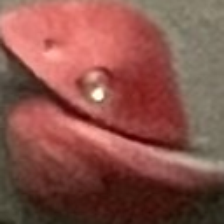


Sample Hold:
Parent image id: IMG_8316.jpeg
Image shape: torch.Size([3, 224, 224])
Hold Type (index): 2
Hold Orientation (index): 3


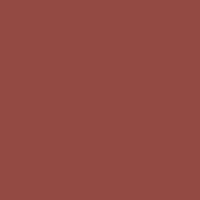

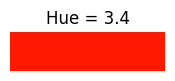

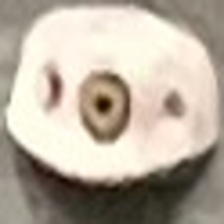


Sample Hold:
Parent image id: IMG_8316.jpeg
Image shape: torch.Size([3, 224, 224])
Hold Type (index): 3
Hold Orientation (index): 0


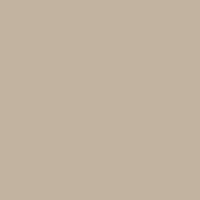

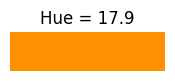

In [35]:
hold1 = 197
hold2 = 199

print_sample_hold(dataset[hold1])

h,s,v = hsv_color_model(dataset.holds[hold1], 'data/images')

visualize_hsv_color((h,s,v))
visualize_hue(h)

print_sample_hold(dataset[hold2])

h,s,v = hsv_color_model(dataset.holds[hold2], 'data/images')

visualize_hsv_color((h,s,v))
visualize_hue(h)

HSV Histogram

In [27]:
def hsv_histogram_model(annotation, images_dir, 
                        h_bins=30, s_bins=30, v_bins=30):
    """
    Computes H, S, V histograms for the object region
    defined by the full-image RLE segmentation.

    Returns:
        (h_hist, s_hist, v_hist)
        Each histogram is normalized (sum = 1).
    """
    img_path = img_path = os.path.join(images_dir, annotation["image_id"])
    segmentation = annotation["segmentation"]

    img = Image.open(img_path).convert("RGB")
    img = ImageOps.exif_transpose(img)

    # Decode full-size RLE mask
    mask = decode_coco_rle(segmentation)

    # Convert image to numpy RGB
    rgb = np.array(img)

    # Extract object pixels
    object_pixels = rgb[mask == 1]

    if len(object_pixels) == 0:
        return None, None, None

    # Convert to HSV
    hsv = cv2.cvtColor(object_pixels.reshape(-1,1,3), cv2.COLOR_RGB2HSV)
    H = hsv[:,0,0]
    S = hsv[:,0,1]
    V = hsv[:,0,2]

    # Compute histograms
    h_hist, _ = np.histogram(H, bins=h_bins, range=(0,179), density=True)
    s_hist, _ = np.histogram(S, bins=s_bins, range=(0,255), density=True)
    v_hist, _ = np.histogram(V, bins=v_bins, range=(0,255), density=True)

    return h_hist, s_hist, v_hist, np.mean(H)

In [28]:

def plot_hsv_histograms(h_hist, s_hist, v_hist):
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.bar(range(len(h_hist)), h_hist)
    plt.title("Hue Histogram (0–179)")
    plt.xlabel("Bins")
    plt.ylabel("Density")

    plt.subplot(1,3,2)
    plt.bar(range(len(s_hist)), s_hist)
    plt.title("Saturation Histogram (0–255)")
    plt.xlabel("Bins")

    plt.subplot(1,3,3)
    plt.bar(range(len(v_hist)), v_hist)
    plt.title("Value Histogram (0–255)")
    plt.xlabel("Bins")

    plt.tight_layout()
    plt.show()

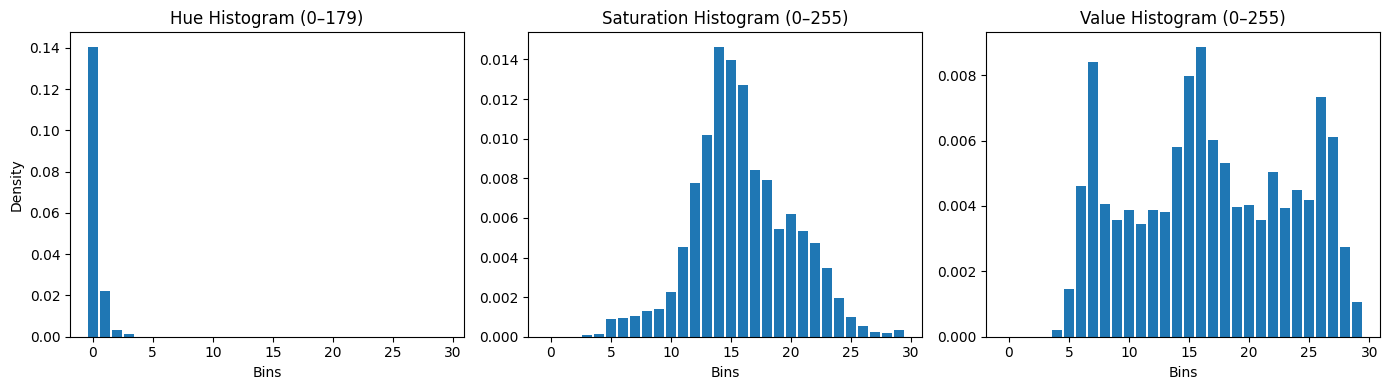

3.3604605521392124


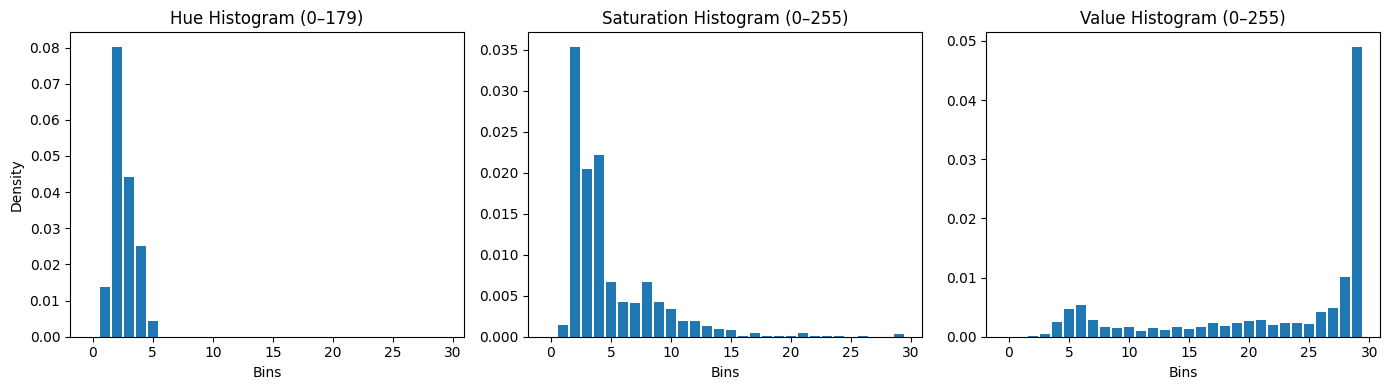

17.91045397750937


In [29]:
h_hist, s_hist, v_hist, H = hsv_histogram_model(dataset.holds[197], 'data/images')

plot_hsv_histograms(h_hist, s_hist, v_hist)
print(H)

h_hist, s_hist, v_hist, H = hsv_histogram_model(dataset.holds[199], 'data/images')

plot_hsv_histograms(h_hist, s_hist, v_hist)
print(H)

In [46]:
hues = []

for hold in dataset.holds:
    h, _, _ = hsv_color_model(hold, 'data/images')
    hues.append(h)

hues = np.array(hues)

np.save('hues.npy', hues)

In [ ]:
def visualize_hues(hues):
    for H in hues[:100]:
        # Make a strip of HSV values where hue = your hue
        hsv_strip = np.zeros((50, 200, 3), dtype=np.uint8)
        hsv_strip[..., 0] = H      # Hue
        hsv_strip[..., 1] = 255    # Full saturation
        hsv_strip[..., 2] = 255    # Full brightness

        # Convert to RGB for proper display
        rgb_strip = cv2.cvtColor(hsv_strip, cv2.COLOR_HSV2RGB)

        plt.figure(figsize=(2,2))
        plt.imshow(rgb_strip)
        plt.title(f"Hue = {H:.1f}")
        plt.axis('off')
        plt.show()

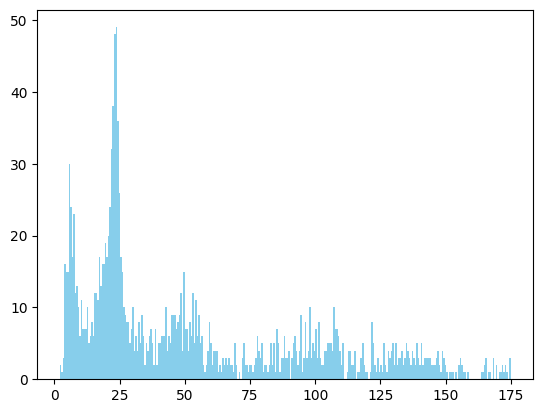

In [54]:
plt.hist(hues, bins=300, color='skyblue')
plt.show()

/var/folders/ln/ccc333gd343_2blclyk9w8wc0000gn/T/ipykernel_72997/2869077175.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2,2))


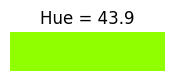

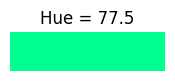

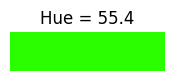

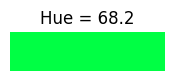

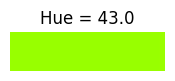

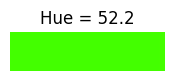

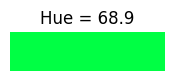

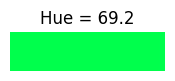

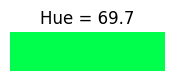

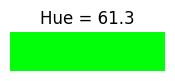

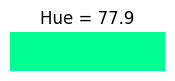

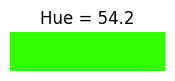

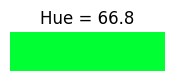

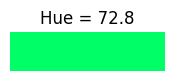

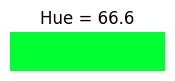

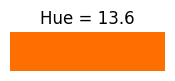

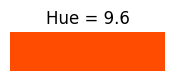

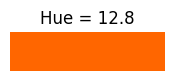

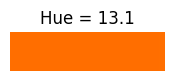

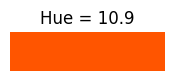

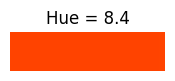

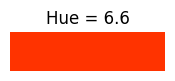

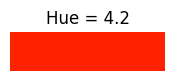

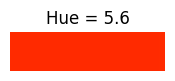

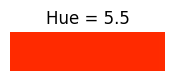

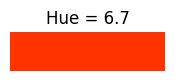

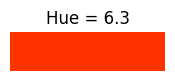

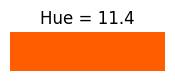

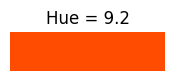

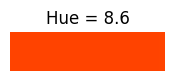

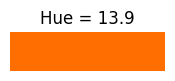

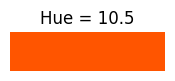

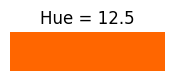

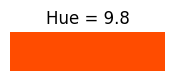

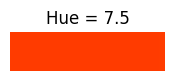

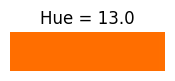

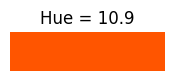

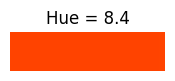

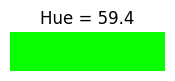

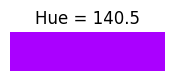

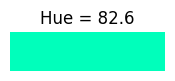

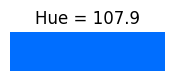

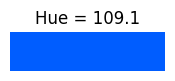

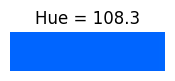

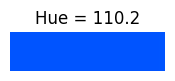

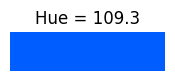

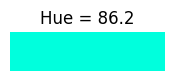

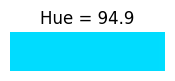

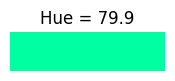

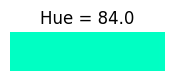

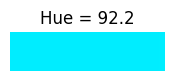

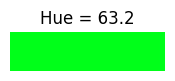

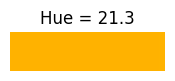

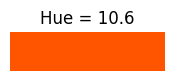

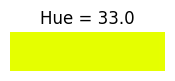

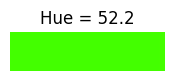

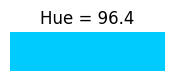

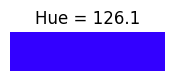

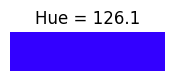

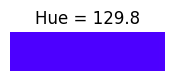

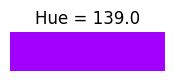

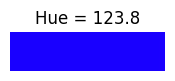

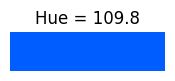

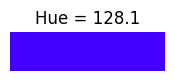

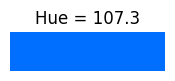

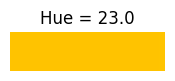

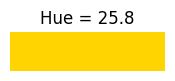

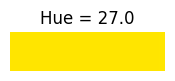

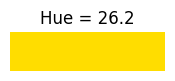

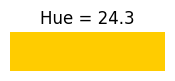

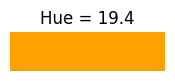

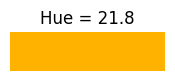

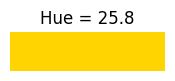

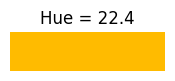

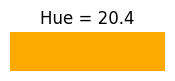

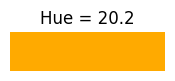

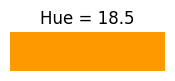

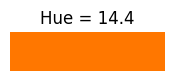

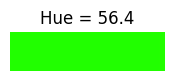

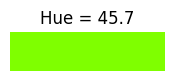

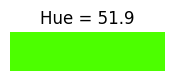

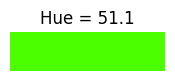

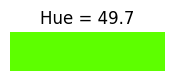

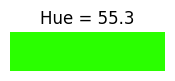

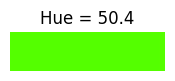

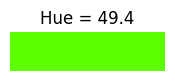

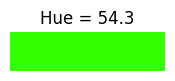

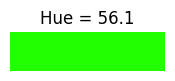

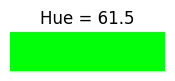

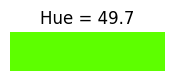

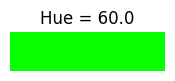

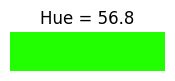

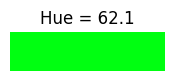

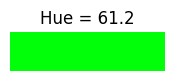

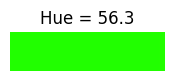

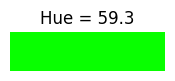

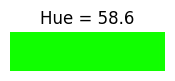

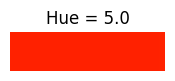

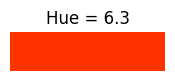

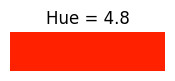

In [50]:
visualize_hues(hues)